In [15]:
import json
import os
import re
import pandas as pd



model = "meta-llama/Llama-2-7b-hf"

model_suffix = model.split("/")[-1]

path = f"../output/{model_suffix}/lora"

# List subdirectories in the path
subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Read JSON files starting with "output" from each subdirectory
data = []
for subdir in subdirs:
    subdir_path = os.path.join(path, subdir)
    json_files = [f for f in os.listdir(subdir_path) if f.startswith("output") and f.endswith(".json")]

    
    # Read each JSON file and extract metrics key which is a key value map
    for json_file in json_files:
        # Get step from the filename which is in the format "output{.}*step=123.json"
        step_match = re.search(r'step=(\d+)', json_file)
        step = int(step_match.group(1)) if step_match else None
        json_path = os.path.join(subdir_path, json_file)
        with open(json_path, 'r') as f:
            json_data = json.load(f)
            metrics = json_data.get("metrics", {})
            ppl = json_data.get("ppl", {}).get("mean", None)
            json_data = { 
                "step": step,
                "subdir": subdir,
                "ppl": ppl,
                **metrics
            }

            data.append(json_data)
# Create a DataFrame from the collected data
df = pd.DataFrame(data)


In [16]:
# Filter out rows that have subdir ending with targeted

df = df[~df['subdir'].str.endswith("targeted")]

In [17]:
df

,step,subdir,ppl,auroc,best_f1_score,tpr_1_fpr,tpr_0.1_fpr
0,2500,mb_k64,17.030703,0.720908,0.700965,0.063333,0.0040
1,2000,mb_k64,17.698578,0.724154,0.694669,0.056000,0.0070
2,1500,mb_k64,17.869968,0.745440,0.714399,0.075333,0.0070
3,1000,mb_k64,19.051359,0.802566,0.751724,0.120667,0.0120
4,500,mb_k64,16.549547,0.960896,0.902111,0.570000,0.2310
5,0,mb_k64,13.901281,0.998780,0.994985,0.996667,0.9820
6,2500,mb_k32,15.060657,0.735128,0.702658,0.114000,0.0250
7,2000,mb_k32,15.172688,0.751444,0.719547,0.128000,0.0460
8,1500,mb_k32,15.657078,0.763754,0.722813,0.134000,0.0310
9,1000,mb_k32,16.054516,0.778740,0.733894,0.148000,0.0470


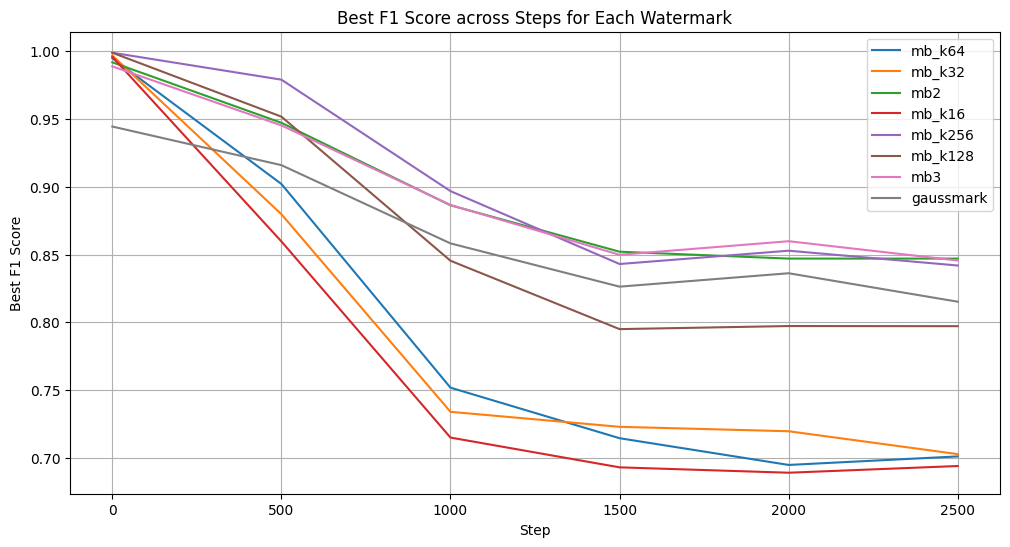

In [38]:
# Plot auroc across steps for each subdir
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for subdir in df['subdir'].unique():
    subdir_data = df[df['subdir'] == subdir]
    # Sort by step
    subdir_data = subdir_data.sort_values(by='step')

    assert len(subdir_data['step']) == len(subdir_data['auroc']), "Step and AUROC lengths do not match for each watermark: " + subdir

    plt.plot(subdir_data['step'], subdir_data['best_f1_score'], label=subdir)
plt.xlabel('Step')
plt.ylabel('Best F1 Score')
plt.title('Best F1 Score across Steps for Each Watermark')
plt.legend()
plt.grid()
plt.show()

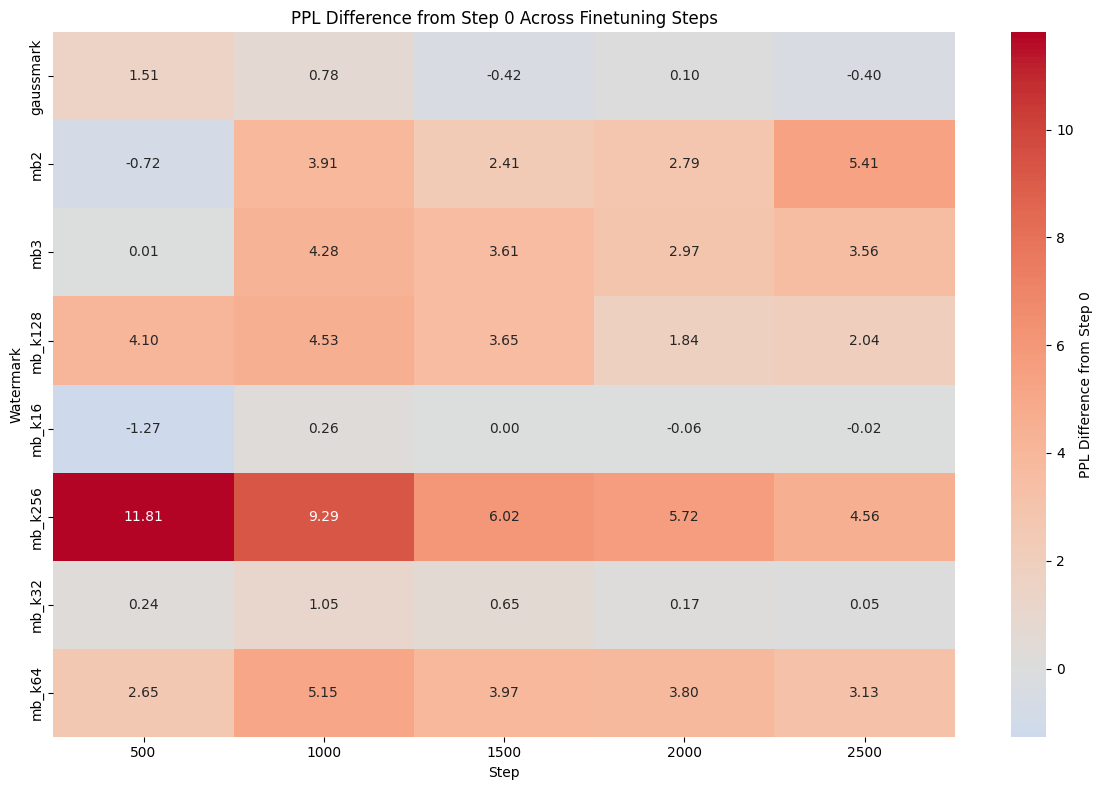

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume df has columns: subdir, step, ppl

# Get step 0 PPL per subdir
step0_ppl = df[df['step'] == 0][['subdir', 'ppl']].set_index('subdir')['ppl']

# Map step 0 PPL to all rows
df['step0_ppl'] = df['subdir'].map(step0_ppl)

# Compute difference from step 0
df['ppl_diff'] = df['ppl'] - df['step0_ppl']

# Pivot to create heatmap matrix: rows=subdir, columns=step
heatmap_data = df.pivot(index='subdir', columns='step', values='ppl_diff')

# Exclude step 0 from the heatmap
heatmap_data = heatmap_data.drop(columns=[0], errors='ignore')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', center=0, cbar_kws={'label': 'PPL Difference from Step 0'})
plt.title('PPL Difference from Step 0 Across Finetuning Steps')
plt.xlabel('Step')
plt.ylabel('Watermark')
plt.tight_layout()
plt.show()
